In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import genpareto
from math import sqrt
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.cnn import cnn_4layer
from model.mlp import mlp_layer

2024-01-10 12:31:32.315120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [68]:
import random

random.seed(10)
print(random.random())

0.5714025946899135


In [69]:
dataset = pd.read_csv('../../data/energy_weather.csv', index_col=0)
# https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


### Preprocess

In [70]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (34980, 2184)


In [71]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 1872) (24486, 12) (5247, 1872) (5247, 12) (5247, 1872) (5247, 12)


In [72]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 72, 26) (24486, 12) (5247, 72, 26) (5247, 12) (5247, 72, 26) (5247, 12)


### PM threshold

In [73]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(24486,)
(5247,)
(5247,)


In [74]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.7037105569454176


In [75]:
len(train_X_pm[train_X_pm > percentile_pm])

696

In [76]:
# Extract excesses over the threshold from the heavy pm data only
excesses = np.abs(train_X_pm[train_X_pm > percentile_pm] - percentile_pm)
excesses.shape

(696,)

In [77]:
# Fit Generalized Pareto Distribution (GPD) to excesses - returns shape (c), loc, scale for fitted distribution
c, loc, scale = genpareto.fit(excesses)


# Define a function to calculate weights based on the survival function of the GPD
def calculate_weights(pm, c, loc, scale, threshold):
    """
    survival function, also known as the complementary cumulative distribution function (CCDF), 
    is a function that gives the probability that a random variable X is greater than a certain value x
    """
    # Weights are the inverse of the survival function
    weights = np.where(pm > threshold, 
                       1 / (1 - genpareto.cdf(pm-threshold, c, loc=loc, scale=scale)),
#                        1 - genpareto.cdf(threshold - loc, c, loc=loc, scale=scale),
                       1.0
                      )  # Assign a default weight of 1 for non-extreme events

    # Normalize weights (optional, for stability in training)
    weights /= np.max(weights)
#     weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights)) + 0.1
#     weights = weights + 0.1
#     weights = np.exp(weights)
#     weights /= np.sum(weights)
    return weights

# Calculate weights for each sample in your dataset
weights = calculate_weights(train_X_pm, c, loc, scale, percentile_pm)
weights.shape

(24486,)

(array([2.3873e+04, 5.9000e+01, 9.8000e+01, 7.2000e+01, 7.5000e+01,
        6.3000e+01, 3.7000e+01, 2.3000e+01, 2.7000e+01, 2.5000e+01,
        2.4000e+01, 1.6000e+01, 1.4000e+01, 2.2000e+01, 2.0000e+01,
        1.4000e+01, 9.0000e+00, 4.0000e+00, 7.0000e+00, 4.0000e+00]),
 array([0.18535948, 0.2260915 , 0.26682353, 0.30755556, 0.34828758,
        0.38901961, 0.42975163, 0.47048366, 0.51121569, 0.55194771,
        0.59267974, 0.63341177, 0.67414379, 0.71487582, 0.75560784,
        0.79633987, 0.8370719 , 0.87780392, 0.91853595, 0.95926797,
        1.        ]),
 <BarContainer object of 20 artists>)

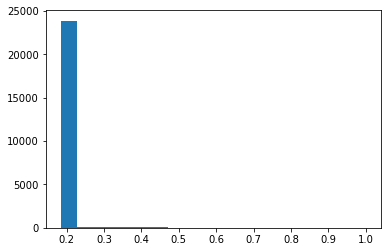

In [78]:
plt.hist(weights, bins=20)

In [82]:
np.save('sample_weights_price_EVT.npy', weights)

### Model

In [79]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [80]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [81]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/price_all_weighted_EVT_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=weights
         )

Epoch 1/1000
48/48 - 2s - loss: 0.0070 - mae: 0.1356 - val_loss: 0.0148 - val_mae: 0.0973

Epoch 00001: val_mae improved from inf to 0.09725, saving model to ../../saved_models/energy_all_weighted_EVT_95.h5
Epoch 2/1000
48/48 - 1s - loss: 0.0020 - mae: 0.0789 - val_loss: 0.0129 - val_mae: 0.0905

Epoch 00002: val_mae improved from 0.09725 to 0.09047, saving model to ../../saved_models/energy_all_weighted_EVT_95.h5
Epoch 3/1000
48/48 - 1s - loss: 0.0017 - mae: 0.0725 - val_loss: 0.0111 - val_mae: 0.0852

Epoch 00003: val_mae improved from 0.09047 to 0.08522, saving model to ../../saved_models/energy_all_weighted_EVT_95.h5
Epoch 4/1000
48/48 - 1s - loss: 0.0012 - mae: 0.0597 - val_loss: 0.0065 - val_mae: 0.0622

Epoch 00004: val_mae improved from 0.08522 to 0.06216, saving model to ../../saved_models/energy_all_weighted_EVT_95.h5
Epoch 5/1000
48/48 - 1s - loss: 7.8270e-04 - mae: 0.0484 - val_loss: 0.0061 - val_mae: 0.0604

Epoch 00005: val_mae improved from 0.06216 to 0.06044, saving mod

48/48 - 1s - loss: 1.8300e-04 - mae: 0.0239 - val_loss: 0.0084 - val_mae: 0.0701

Epoch 00052: val_mae did not improve from 0.05202
Epoch 53/1000
48/48 - 1s - loss: 1.8022e-04 - mae: 0.0237 - val_loss: 0.0084 - val_mae: 0.0694

Epoch 00053: val_mae did not improve from 0.05202
Epoch 54/1000
48/48 - 1s - loss: 1.8376e-04 - mae: 0.0240 - val_loss: 0.0087 - val_mae: 0.0714

Epoch 00054: val_mae did not improve from 0.05202
Epoch 55/1000
48/48 - 1s - loss: 1.7636e-04 - mae: 0.0235 - val_loss: 0.0088 - val_mae: 0.0712

Epoch 00055: val_mae did not improve from 0.05202
Epoch 56/1000
48/48 - 1s - loss: 1.8613e-04 - mae: 0.0242 - val_loss: 0.0092 - val_mae: 0.0733

Epoch 00056: val_mae did not improve from 0.05202
Epoch 57/1000
48/48 - 1s - loss: 1.7387e-04 - mae: 0.0233 - val_loss: 0.0084 - val_mae: 0.0697

Epoch 00057: val_mae did not improve from 0.05202
Epoch 58/1000
48/48 - 1s - loss: 1.6573e-04 - mae: 0.0227 - val_loss: 0.0094 - val_mae: 0.0741

Epoch 00058: val_mae did not improve from 


Epoch 00108: val_mae did not improve from 0.05202
Epoch 109/1000
48/48 - 1s - loss: 9.0994e-05 - mae: 0.0169 - val_loss: 0.0110 - val_mae: 0.0809

Epoch 00109: val_mae did not improve from 0.05202
Epoch 110/1000
48/48 - 1s - loss: 8.7940e-05 - mae: 0.0166 - val_loss: 0.0112 - val_mae: 0.0815

Epoch 00110: val_mae did not improve from 0.05202
Epoch 111/1000
48/48 - 1s - loss: 9.1076e-05 - mae: 0.0169 - val_loss: 0.0121 - val_mae: 0.0859

Epoch 00111: val_mae did not improve from 0.05202
Epoch 112/1000
48/48 - 1s - loss: 1.0252e-04 - mae: 0.0180 - val_loss: 0.0119 - val_mae: 0.0850

Epoch 00112: val_mae did not improve from 0.05202
Epoch 113/1000
48/48 - 1s - loss: 1.2032e-04 - mae: 0.0196 - val_loss: 0.0115 - val_mae: 0.0834

Epoch 00113: val_mae did not improve from 0.05202
Epoch 114/1000
48/48 - 1s - loss: 9.0564e-05 - mae: 0.0169 - val_loss: 0.0112 - val_mae: 0.0818

Epoch 00114: val_mae did not improve from 0.05202
Epoch 115/1000
48/48 - 1s - loss: 8.6902e-05 - mae: 0.0165 - val_lo


Epoch 00164: val_mae did not improve from 0.05202
Epoch 165/1000
48/48 - 1s - loss: 6.2360e-05 - mae: 0.0140 - val_loss: 0.0123 - val_mae: 0.0859

Epoch 00165: val_mae did not improve from 0.05202
Epoch 166/1000
48/48 - 1s - loss: 6.0923e-05 - mae: 0.0137 - val_loss: 0.0123 - val_mae: 0.0858

Epoch 00166: val_mae did not improve from 0.05202
Epoch 167/1000
48/48 - 1s - loss: 6.0616e-05 - mae: 0.0137 - val_loss: 0.0120 - val_mae: 0.0846

Epoch 00167: val_mae did not improve from 0.05202
Epoch 168/1000
48/48 - 1s - loss: 9.0852e-05 - mae: 0.0170 - val_loss: 0.0127 - val_mae: 0.0875

Epoch 00168: val_mae did not improve from 0.05202
Epoch 169/1000
48/48 - 1s - loss: 7.1277e-05 - mae: 0.0150 - val_loss: 0.0119 - val_mae: 0.0840

Epoch 00169: val_mae did not improve from 0.05202
Epoch 170/1000
48/48 - 1s - loss: 6.7106e-05 - mae: 0.0145 - val_loss: 0.0119 - val_mae: 0.0842

Epoch 00170: val_mae did not improve from 0.05202
Epoch 171/1000
48/48 - 1s - loss: 6.7581e-05 - mae: 0.0146 - val_lo